## Data Collection

In [1]:
!pip install -q kaggle

In [2]:
#!/bin/bash
!kaggle datasets download riyaelizashaju/skin-disease-classification-image-dataset

Dataset URL: https://www.kaggle.com/datasets/riyaelizashaju/skin-disease-classification-image-dataset
License(s): unknown
 91% 153M/169M [00:00<00:00, 184MB/s]
100% 169M/169M [00:00<00:00, 201MB/s]


In [3]:
!unzip skin-disease-classification-image-dataset.zip -d dataset

Archive:  skin-disease-classification-image-dataset.zip
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024468.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024470.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024707.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024763.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024771.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024800.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024913.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024948.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0025780.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0025953.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0025957.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0025992.jpg  
  inflating: dataset/Split_smol/train/Actini

# Importing Libraries

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image

In [5]:
# Set directories for train and validation datasets
train_dir = "/content/dataset/Split_smol/train"
val_dir = "/content/dataset/Split_smol/val"

In [6]:

# Define the classes to include
selected_classes = ["Actinic keratosis", "Atopic Dermatitis", "Benign keratosis", "Dermatofibroma"]

In [7]:
# Image data augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create generators for loading and augmenting data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    classes=selected_classes,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    classes=selected_classes,
    class_mode='categorical'
)


Found 321 images belonging to 4 classes.
Found 81 images belonging to 4 classes.


In [8]:
# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of EfficientNetB0
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(selected_classes), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("efficientnetb0_best_model.keras", monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.2437 - loss: 1.3937 - val_accuracy: 0.2469 - val_loss: 1.3865
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.2572 - loss: 1.3871 - val_accuracy: 0.2469 - val_loss: 1.3866
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.2345 - loss: 1.3905 - val_accuracy: 0.2469 - val_loss: 1.3870
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.1967 - loss: 1.3903 - val_accuracy: 0.2469 - val_loss: 1.3876
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.1874 - loss: 1.3951 - val_accuracy: 0.2469 - val_loss: 1.3878
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.2202 - loss: 1.3935 - val_accuracy: 0.2469 - val_loss: 1.3884


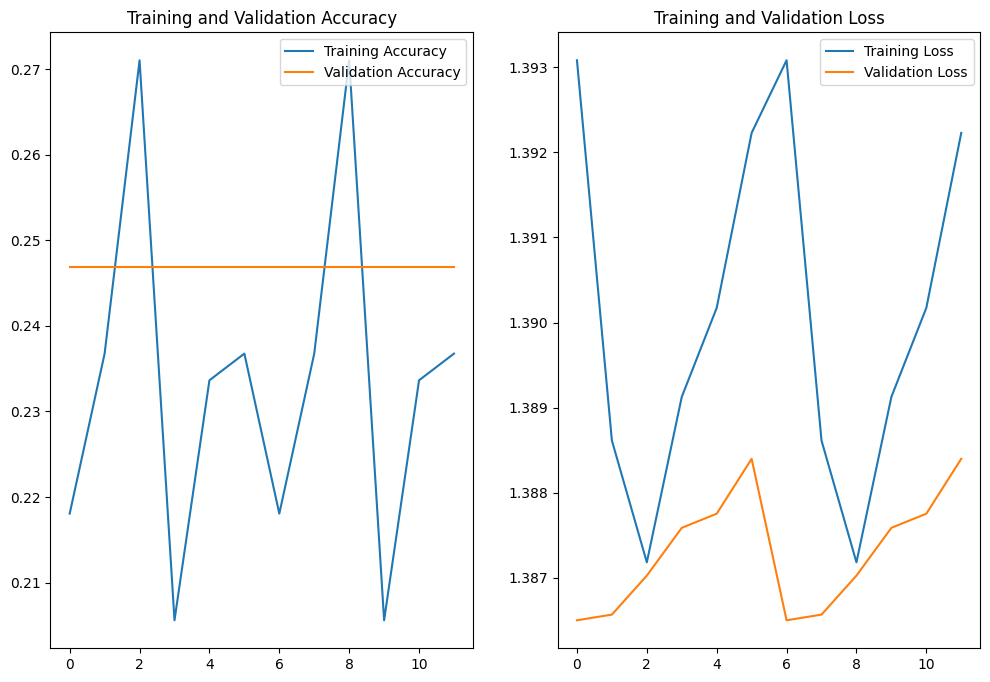

In [10]:
# Plot Training History
def plot_training_history(history, fhistory):
    acc = history.history['accuracy'] + fhistory.history['accuracy']
    val_acc = history.history['val_accuracy'] + fhistory.history['val_accuracy']
    loss = history.history['loss'] + fhistory.history['loss']
    val_loss = history.history['val_loss'] + fhistory.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
plot_training_history(history,history)



**Finetuning the Model**

In [11]:
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.2464 - loss: 1.4238 - val_accuracy: 0.2593 - val_loss: 1.3862
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.2458 - loss: 1.4466 - val_accuracy: 0.2593 - val_loss: 1.3865
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.2573 - loss: 1.4022 - val_accuracy: 0.2593 - val_loss: 1.3891
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.2276 - loss: 1.4256 - val_accuracy: 0.2593 - val_loss: 1.3951
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.2898 - loss: 1.4219 - val_accuracy: 0.2593 - val_loss: 1.3977
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.2714 - loss: 1.4097 - val_accuracy: 0.2593 - val_loss: 1.3990


In [12]:
# Save the final model
model.save("efficientnetb0_dermatitis_model.keras")

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.2468 - loss: 1.3867
Validation Loss: 1.3862
Validation Accuracy: 0.2593


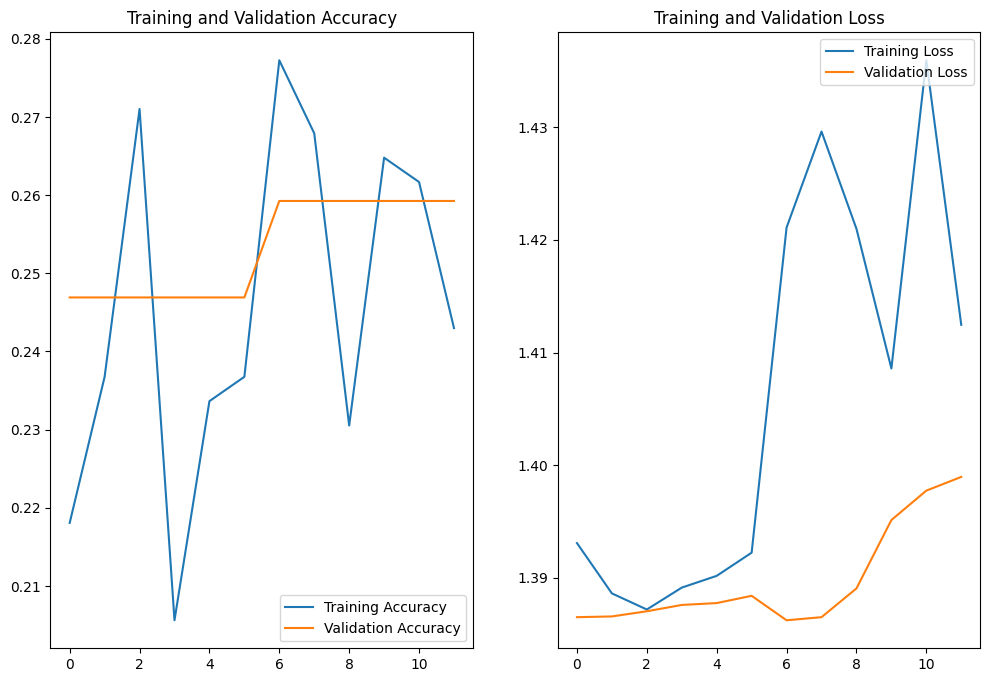

In [13]:
# Visualization of Training History
def plot_training_history(history, fine_tune_history):
    acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
    loss = history.history['loss'] + fine_tune_history.history['loss']
    val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history, fine_tune_history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step


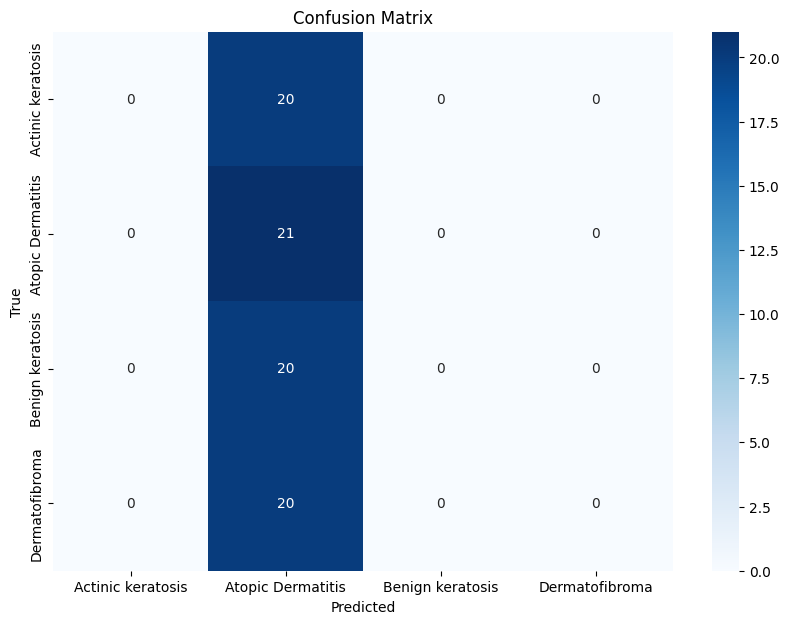

In [14]:
# Generate Confusion Matrix
true_labels = val_generator.classes
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
# Classification Report
report = classification_report(true_labels, predicted_classes, target_names=val_generator.class_indices.keys())
print("Classification Report:")
print(report)

Classification Report:
                   precision    recall  f1-score   support

Actinic keratosis       0.00      0.00      0.00        20
Atopic Dermatitis       0.26      1.00      0.41        21
 Benign keratosis       0.00      0.00      0.00        20
   Dermatofibroma       0.00      0.00      0.00        20

         accuracy                           0.26        81
        macro avg       0.06      0.25      0.10        81
     weighted avg       0.07      0.26      0.11        81



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


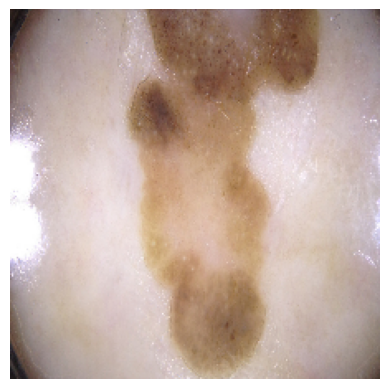

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Class: Atopic Dermatitis with Confidence: 25.84%


In [17]:
# Predict a Single Test Image
def predict_single_image(model, image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_labels = list(train_generator.class_indices.keys())

    print(f"Predicted Class: {class_labels[predicted_class]} with Confidence: {np.max(prediction) * 100:.2f}%")

# Test with an example image
predict_single_image(model, "/content/dataset/Split_smol/val/Benign keratosis/ISIC_0014605_downsampled.jpg")
